In [4]:
import bh_spc
from bh_spc import spcm

import time
import matplotlib.pyplot as plt
import numpy as np

In [43]:
with bh_spc.ini_file(
    bh_spc.minimal_spcm_ini(spcm.DLLOperationMode.SIMULATE_SPC_130EM)
) as ini:
    spcm.init(ini)

In [44]:
mod_no = 0

In [45]:
#spcm.get_init_status(mod_no)
#spcm.set_mode(spcm.DLLOperationMode.HARDWARE, True, [True])
status = spcm.get_init_status(mod_no)
print(status == spcm.InitStatus.OK)

True


In [46]:
spcm.set_parameter(mod_no, spcm.ParID.MODE, 1)

In [47]:
params = spcm.get_parameters(mod_no)

#for par, val in params.items():
#    print(f"{par} = {val}")

print(params)

<Data(cfd_limit_low=-0.0, cfd_limit_high=80.0, cfd_zc_level=0.0, cfd_holdoff=5.0, sync_zc_level=0.0, sync_freq_div=4, sync_holdoff=4.0, sync_threshold=-19.60784339904785, tac_range=50.033573150634766, tac_gain=1, tac_offset=0.0, tac_limit_low=10.196078300476074, tac_limit_high=80.0, adc_resolution=12, ext_latch_delay=0, collect_time=0.009999999776482582, display_time=1.0, repeat_time=10.0, stop_on_time=1, stop_on_ovfl=1, dither_range=0, count_incr=1, mem_bank=0, dead_time_comp=0, scan_control=0, routing_mode=0, tac_enable_hold=0.0, mode=1, scan_size_x=1, scan_size_y=1, scan_rout_x=1, scan_rout_y=1, scan_polarity=0, scan_flyback=65537, scan_borders=0, pixel_time=2.0000000233721948e-07, pixel_clock=0, line_compression=1, trigger=0, ext_pixclk_div=1, rate_count_time=1.0, macro_time_clk=0, add_select=0, adc_zoom=0, xy_gain=1, img_size_x=1, img_size_y=1, img_rout_x=1, img_rout_y=1, master_clock=2, adc_sample_delay=0, detector_type=1, tdc_control=0, chan_enable=4191231, chan_slope=0, chan_sp

In [48]:
# For this demonstration, we will turn off `stop_on_time`, mostly because it
# does not appear to work in simulation mode. By turning it off, running this
# example on real hardware should behave the same way.
params.stop_on_time = 0

# (Set other parameters here!)

spcm.set_parameters(mod_no, params)

In [49]:
duration = 3 # s
buf_size = 32768  # Max number of 16-bit words in a single read.

spcm.start_measurement(mod_no)
start_time = time.monotonic()

data = []  # Collect arrays of data into a list.
while True:
    elapsed = time.monotonic() - start_time
    if elapsed >= duration:
        spcm.stop_measurement(mod_no)
        break
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if len(buf):
        data.append(buf)
    if len(buf) < buf_size:  # We've read all there is to read.
        time.sleep(0.001)

# Make sure to read the data that arrived after stopping (if you need it).
while True:
    buf = spcm.read_fifo_to_array(mod_no, buf_size)
    if not len(buf):
        break
    data.append(buf)

In [52]:
records = np.concatenate(data).view(np.uint32)
print(len(records))
photons = np.extract(np.bitwise_and(records, 0b1001 << 28) == 0, records)
print(len(photons))

max_12bit = (1 << 12) - 1  # 4095
microtimes = np.bitwise_and(np.right_shift(photons, 16), max_12bit)

# Reverse the microtimes by subtracting from the max value, because the raw
# microtime is measured from photon to SYNC, not SYNC to photon.
microtimes = max_12bit - microtimes
microtimes

12518326
12517372


array([ 562, 3686, 1688, ...,  678, 1965,  936], dtype=uint32)

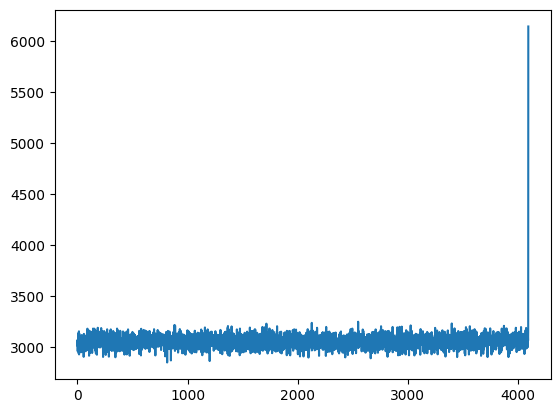

In [51]:
time_bins = np.arange(4096) #* data.tac_range / 4096
histogram, bin_edges = np.histogram(microtimes, bins=time_bins)
bin_edges = bin_edges[:-1] #* params.tac_range / (params.tac_gain * 4096)
plt.plot(bin_edges, histogram)
plt.show()